In [91]:
import netket as nk
import netket.experimental as nkx
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from time import time
import jax.numpy as jnp
from netket.operator.spin import sigmax, sigmay, sigmaz

1 - Heisenberg Chain

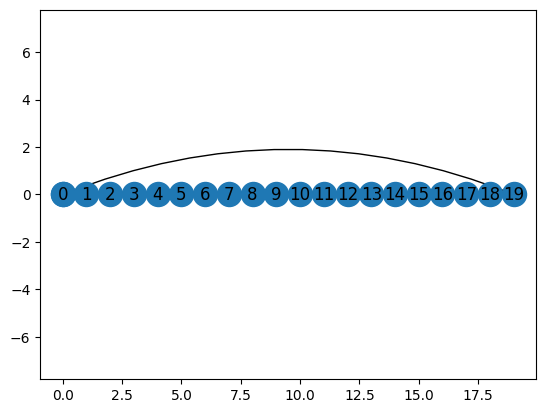

In [64]:
L = 20
chain = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
chain.draw();

In [65]:
hilbert = nk.hilbert.Spin(s=1/2, total_sz=0, N=chain.n_nodes)
hilbert, hilbert.n_states

(Spin(s=1/2, total_sz=0, N=20), 184756)

In [66]:
hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=chain, J=1)
hamiltonian.n_operators

20

In [67]:
rbm = nk.models.RBM(alpha=1, param_dtype=complex)
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=chain)
optimizer = nk.optimizer.Sgd(learning_rate=0.01)
sr = nk.optimizer.SR(diag_shift=0.1)
vstate = nk.vqs.MCState(sampler, rbm, n_samples=1008)
vstate

MCState(
  hilbert = Spin(s=1/2, total_sz=0, N=20),
  sampler = MetropolisSampler(rule = ExchangeRule(# of clusters: 20), n_chains = 16, sweep_size = 20, reset_chains = False, machine_power = 2, dtype = <class 'float'>),
  n_samples = 1008,
  n_discard_per_chain = 100,
  sampler_state = MetropolisSamplerState(rng state=[ 657101043 3775359973]),
  n_parameters = 440)

In [68]:
gs = nk.VMC(hamiltonian=hamiltonian, optimizer=optimizer, preconditioner=sr, variational_state=vstate)

start = time()
gs.run(n_iter=500, out='./results/CHAIN')
print(f'Time: {time()-start:.3f} seconds')

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\netket\optimizer\qgt\qgt_onthefly.py:109: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_g

Time: 83.661 seconds


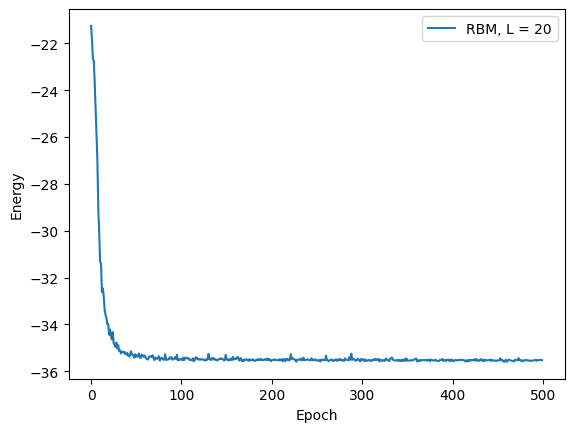

In [75]:
data_chain = json.load(open('./results/CHAIN.log'))
figure, axes = plt.subplots(1, 1)
axes.plot(data_chain['Energy']['iters'], data_chain['Energy']['Mean']['real'], label=f'RBM, L = {L}')
axes.set(xlabel='Epoch', ylabel='Energy')
axes.legend();

Time evolution

In [76]:
observables = {'sz': sum(nk.operator.spin.sigmaz(hilbert, i) for i in range(L))}
observables['sz']

LocalOperator(dim=20, #acting_on=20 locations, constant=0.0, dtype=float64)

In [77]:
integrator = nkx.dynamics.Heun(dt=0.001)
qgt = nk.optimizer.qgt.QGTJacobianDense(holomorphic=True)
te = nkx.TDVP(hamiltonian, vstate, integrator, qgt=qgt)
te, integrator

(TDVP(step_count=0, t=0.0),
 RKIntegratorConfig(tableau=Heun, dt=0.001, adaptive=False))

In [78]:
start = time()
te.run(T=1.0, out='./results/chain_te_log', obs=observables)
print(f'Time: {time()-start:.3f} seconds')

  0%|          | 0.00/1.00 [00:00<?, ?it/s]

Time: 690.236 seconds


Honeycomb Heisenberg

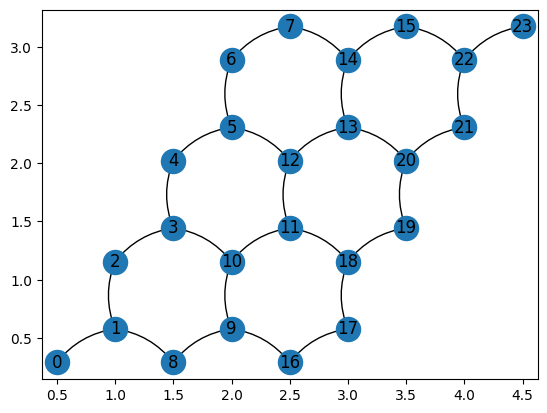

In [82]:
honey = nk.graph.Honeycomb(extent=[3, 4], pbc=False)
honey.draw();

In [83]:
hilbert = nk.hilbert.Spin(s=1/2, total_sz=0, N=honey.n_nodes)
hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=honey, J=1)
rbm = nk.models.RBM(alpha=1)
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=honey)
optimizer = nk.optimizer.Sgd(learning_rate=0.01)
sr = nk.optimizer.SR(diag_shift=0.1)
vstate = nk.vqs.MCState(sampler, rbm, n_samples=1008)
gs = nk.VMC(hamiltonian=hamiltonian, optimizer=optimizer, preconditioner=sr, variational_state=vstate)
start = time()
gs.run(n_iter=500, out='./results/HONEY')
print(f'Time: {time()-start:.3f} seconds')

  0%|          | 0/500 [00:00<?, ?it/s]

Time: 34.849 seconds


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Energy')]

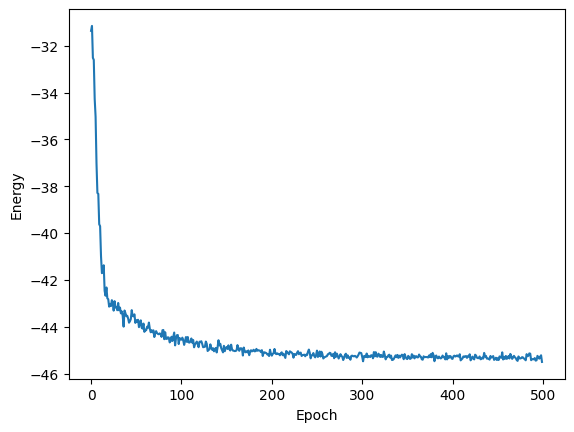

In [98]:
data_honey = json.load(open('./results/HONEY.log'))
figure, axes = plt.subplots(1, 1)
axes.plot(data_honey['Energy']['iters'], data_honey['Energy']['Mean'])
axes.set(xlabel='Epoch', ylabel='Energy')

Kitaev Model

In [85]:
kitaev = nk.graph.KitaevHoneycomb(extent=[3, 4], pbc=False)
dict(zip(kitaev.edges(), kitaev.edge_colors))

{(0, 1): 0,
 (2, 3): 0,
 (4, 5): 0,
 (6, 7): 0,
 (8, 9): 0,
 (10, 11): 0,
 (12, 13): 0,
 (14, 15): 0,
 (16, 17): 0,
 (18, 19): 0,
 (20, 21): 0,
 (22, 23): 0,
 (1, 8): 1,
 (3, 10): 1,
 (5, 12): 1,
 (7, 14): 1,
 (9, 16): 1,
 (11, 18): 1,
 (13, 20): 1,
 (15, 22): 1,
 (1, 2): 2,
 (3, 4): 2,
 (5, 6): 2,
 (9, 10): 2,
 (11, 12): 2,
 (13, 14): 2,
 (17, 18): 2,
 (19, 20): 2,
 (21, 22): 2}

In [87]:
def draw_kitaev_honeycomb(lattice, ax=None, node_color='powderblue', node_size=300, 
                          figsize=None, curvature=0.2, font_size=12, font_color='k'):
    edge_colormap = dict(zip(lattice.edges(), lattice.edge_colors))
    edge_colors = {0: 'red', 1: 'blue', 2: 'green'}
    edge_labels = ['J_x', 'J_y', 'J_z']
    positions = lattice.positions
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize, layout='constrained')
    zorder, annotation = 1, None
    for edge in lattice.edges():
        x1, y1 = positions[edge[0]]
        x2, y2 = positions[edge[1]]
        arrowprops = dict(arrowstyle='-', shrinkA=0, shrinkB=0, patchA=None, patchB=None,
                          connectionstyle=f'arc3,rad={curvature}',
                          color=edge_colors[edge_colormap[edge]])
        annotation = ax.annotate('', xy=(x1, y1), xycoords='data', 
                                 xytext=(x2, y2), textcoords='data',
                                 arrowprops=arrowprops)
    else:
        zorder = annotation.get_zorder() + 1
    ax.scatter(*positions.T, s=node_size, c=node_color, 
               marker='o', zorder=zorder)
    for node in lattice.nodes():
        x1, y1 = positions[node]
        ax.text(x1, y1, str(node), 
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=font_size,
                color=font_color,
                zorder=zorder)
    ax.set(xticks=[], yticks=[])
    legend_lines = [Patch(color=color, label=f'${label}$')
                    for color, label in zip(edge_colors.values(), edge_labels)]
    ax.legend(handles=legend_lines, loc='upper left')
    return ax

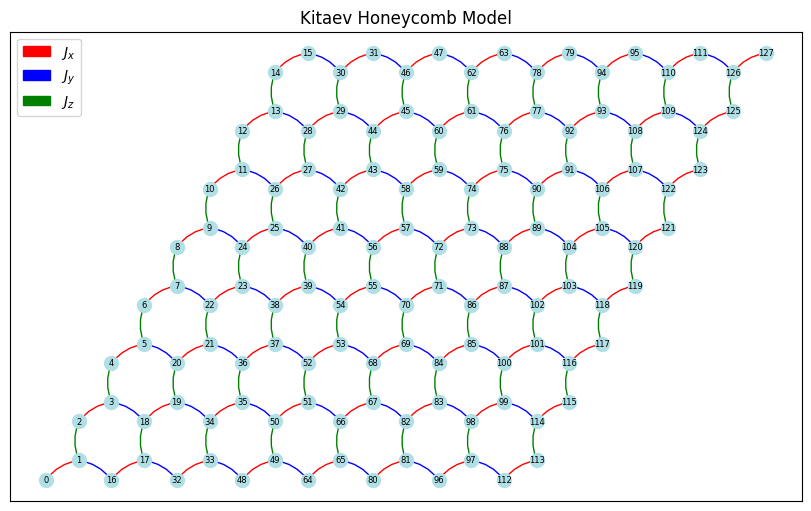

In [89]:
kitaev = nk.graph.KitaevHoneycomb(extent=[8, 8], pbc=False)
figure, axes = plt.subplots(1, 1, figsize=(8, 5), layout='constrained')
draw_kitaev_honeycomb(kitaev, ax=axes, node_size=100, font_size=6)
axes.set(title='Kitaev Honeycomb Model')
figure.savefig('KitaevHoneycomb.png');

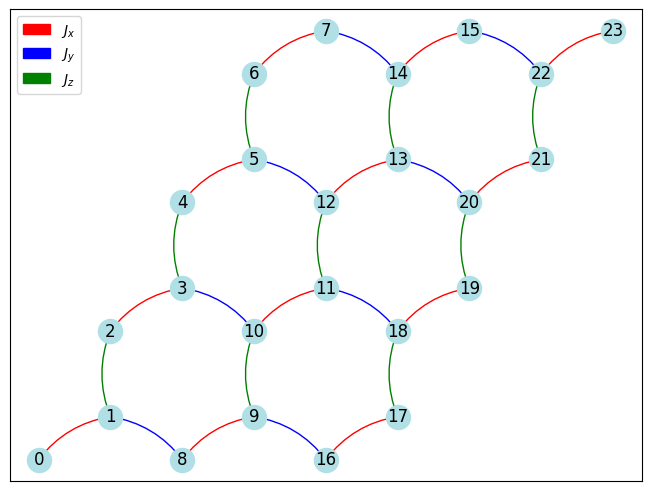

In [90]:
kitaev = nk.graph.KitaevHoneycomb(extent=[3, 4], pbc=False)
draw_kitaev_honeycomb(kitaev);

In [92]:
hilbert = nk.hilbert.Spin(s=1/2, total_sz=0, N=kitaev.n_nodes)
Jx, Jy, Jz = 1.0, 0.1, 0.1
Ji = {0: Jx, 1: Jy, 2: Jz}
operators = {0: sigmax, 1: sigmay, 2: sigmaz}

hamiltonian = nk.operator.LocalOperator(hilbert, dtype=jnp.complex128)
for (i, j), color in zip(kitaev.edges(), kitaev.edge_colors):
    operator = operators[color]
    hamiltonian += -Ji[color] * (operator(hilbert, i) @ operator(hilbert, j))
hamiltonian

LocalOperator(dim=24, #acting_on=29 locations, constant=0j, dtype=complex128)

In [93]:
rbm = nk.models.RBM(alpha=1)
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=kitaev)
optimizer = nk.optimizer.Sgd(learning_rate=0.01)
sr = nk.optimizer.SR(diag_shift=0.1)
vstate = nk.vqs.MCState(sampler, rbm, n_samples=1008)
gs = nk.VMC(hamiltonian=hamiltonian, optimizer=optimizer, preconditioner=sr, variational_state=vstate)
start = time()
gs.run(n_iter=500, out='./results/KITAEV')
print(f'Time: {time()-start:.3f} seconds')

  0%|          | 0/500 [00:00<?, ?it/s]

Time: 30.489 seconds


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Energy')]

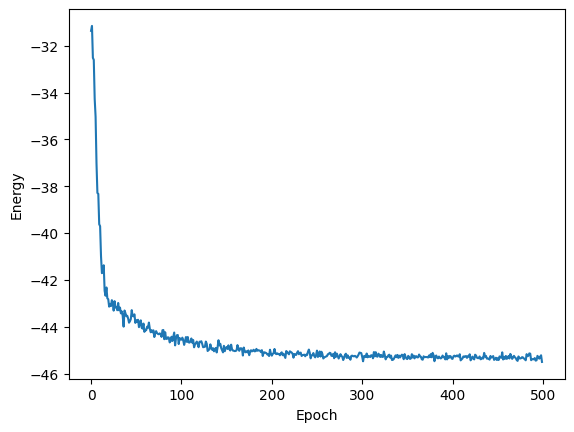

In [97]:
data_kitaev = json.load(open('./results/HONEY.log'))
figure, axes = plt.subplots(1, 1)
axes.plot(data_kitaev['Energy']['iters'], data_kitaev['Energy']['Mean'])
axes.set(xlabel='Epoch', ylabel='Energy')